In [232]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/27642
# 标题：八大机器学习模型大比拼!看看谁的表现最好?

import pandas as pd
import numpy as np
from time import time
import datetime

# 设定最大显示行数、列数为200
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

from jqdata import *
from jqfactor import *
from jqlib.technical_analysis import *
from scipy import stats
import statsmodels.api as sm
from statsmodels import regression
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams["font.family"] = "SimHei"
mpl.rcParams["axes.unicode_minus"] = False
plt.style.use('ggplot')

# 1.数据获取

## 1.1参数设置


In [2]:
# 样本区间
START_DATE = '2010-01-01'
END_DATE = '2020-04-30'

# 指数成份股 ,比较基准 , 这里用ZZ500
INDEX = '399905.XSHE'
# 排名前0.3为1,后0.3为0
percent_select = [0.3, 0.3]  

### 1.1.1财务数据q

In [3]:
q = query(valuation.code, 
      valuation.market_cap,#市值
      valuation.circulating_market_cap,
      valuation.pe_ratio, #市盈率（TTM）
      valuation.pb_ratio, #市净率（TTM）
      valuation.pcf_ratio, #CFP
      valuation.ps_ratio, #PS
      balance.total_assets,
      balance.total_liability,
      balance.fixed_assets,  
      balance.total_non_current_liability,
      income.operating_profit,
      income.total_profit, #OPTP
      indicator.net_profit_to_total_revenue, #净利润/营业总收入
      indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
      indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
      indicator.roe,
      indicator.roa,
      indicator.gross_profit_margin #销售毛利率GPM
    )

### 1.1.2 聚宽因子列表

In [4]:
# get_factor_values()中的参数factors
jqfactor_list = ['current_ratio',
                  'net_profit_to_total_operate_revenue_ttm',
                  'gross_income_ratio',
                  'roe_ttm',
                  'roa_ttm',
                  'total_asset_turnover_rate',
                  'net_operating_cash_flow_coverage',
                  'net_operate_cash_flow_ttm',
                  'net_profit_ttm',
                  'cash_to_current_liability',
                  'operating_revenue_growth_rate',
                  'non_recurring_gain_loss',
                  'operating_revenue_ttm',
                  'net_profit_growth_rate',
                  'AR',
                  'ARBR',
                  'ATR14',
                  'VOL5',
                  'VOL60',
                  'Skewness20',
                  'Skewness60']

## 1.2获取交易日历(月频)

In [5]:
def get_trade_days_monthly(start,end):
    '''
    获取每月月底的交易日的日历
    注意: 结束日期必须是一个月的最后一天
    :param start:
    :param end:
    :return:  list,每月最后一个交易日的列表,里面元素是datetime.date类型
    '''
    # 日频率的交易日历: Index
    index = get_trade_days(start_date=start, end_date=end)
    # 转成一个df , 索引和值都是交易日(天)
    df = pd.DataFrame(index, index=index)
    # 将Index转成DatetimeIndex
    df.index = pd.to_datetime(df.index)
    # 按月重采样,缺失值用上一个填充,那么刚好值就是想要的每月最后一个交易日
    return list(df.resample('m', how='last').iloc[:,0])

## 1.3筛选股票池

In [6]:
# 去除上市距截面期不足n天的股票
def remove_new(stocks,beginDate,n):
    stocklist=[]
    if isinstance(beginDate,str):
        # str转datetime
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        # 去除上市距截面期不足n天的股票
        if start_date<(beginDate-datetime.timedelta(days=n)):
            stocklist.append(stock)
    return stocklist

In [7]:
# 剔除ST股
def remove_st(stocks,beginDate):
    is_st = get_extras('is_st',stocks,end_date=beginDate,count=1)
    return [stock for stock in stocks if not is_st[stock][0]]

In [8]:
# 剔除每个截面期交易日停牌的股票
def remove_paused(stocks,beginDate):
    is_paused = get_price(stocks,end_date=beginDate, count=1,fields='paused',panel=False)
    return list(is_paused[is_paused['paused']!=1]['code'])

In [9]:
def get_stocks_filtered(beginDate,n,indexID=INDEX):
    '''
    获取某一天筛选后的指数成份股
    :param tradedate: 指定某一天
    :param indexID:默认'399905.XSHE'
    :param n : 剔除上市不到n天
    :return:
    '''
    # 获取当天指数成份股列表
    stocklist = get_index_stocks(indexID, date=beginDate)
    stocklist = remove_new(stocklist,beginDate,n)
    stocklist = remove_st(stocklist,beginDate)
    stocklist = remove_paused(stocklist,beginDate)
    return stocklist

## 1.4因子数据获取

In [10]:
def get_df_jqfactor(stocklist,factor_list,date):
    '''
    获取聚宽因子
    stocklist：list,股票列表
    factor_list:list,因子列表
    date: 日期， 字符串或 datetime 对象
    output:
    dataframe, index为股票代码，columns为因子
    '''
    # 返回的是一个字典 {'因子1':df1,...}
    factor_data = get_factor_values(securities=stocklist,
                                    factors=factor_list,
                                    count=1,
                                    end_date=date)
    df_jqfactor=pd.DataFrame(index=stocklist)
    
    for factor in factor_data.keys():
        df_jqfactor[factor]=factor_data[factor].iloc[0,:]
    
    return df_jqfactor

In [11]:
def get_newfactors_df(stocklist,df,date):
    """
    stocklist: 股票列表
    df : 原始因子df
    date : 日期
    return : 新的因子df
    
    """
    
    #净资产
    df['net_assets']=df['total_assets']-df['total_liability']
    df_new = pd.DataFrame(index=stocklist)
        
    #估值因子
    df_new['EP'] = df['pe_ratio'].apply(lambda x: 1/x)
    df_new['BP'] = df['pb_ratio'].apply(lambda x: 1/x)
    df_new['SP'] = df['ps_ratio'].apply(lambda x: 1/x)
#     df_new['RD'] = df['development_expenditure']/(df['market_cap']*100000000)
    df_new['CFP'] = df['pcf_ratio'].apply(lambda x: 1/x)
    
    #杠杆因子
    #对数流通市值
#     df_new['CMV'] = np.log(df['circulating_market_cap'])
    #总资产/净资产
    df_new['financial_leverage']=df['total_assets']/df['net_assets']
    #非流动负债/净资产
    df_new['debtequityratio']=df['total_non_current_liability']/df['net_assets']
    #现金比率=(货币资金+有价证券)÷流动负债
    df_new['cashratio']=df['cash_to_current_liability']
    #流动比率=流动资产/流动负债*100%
    df_new['currentratio']=df['current_ratio']
    
    #财务质量因子
    # 净利润与营业总收入之比
    df_new['NI'] = df['net_profit_to_total_operate_revenue_ttm']
    df_new['GPM'] = df['gross_income_ratio']
    df_new['ROE'] = df['roe_ttm']
    df_new['ROA'] = df['roa_ttm']
    df_new['asset_turnover'] = df['total_asset_turnover_rate']
    df_new['net_operating_cash_flow'] = df['net_operating_cash_flow_coverage']
    
    #成长因子
    df_new['Sales_G_q'] = df['operating_revenue_growth_rate']
    df_new['Profit_G_q'] = df['net_profit_growth_rate']
#     df_new['PEG'] = df['PEG']
    
    #技术指标
    df_new['RSI']=pd.Series(RSI(stocklist, date, N1=20))  
    df_new['BIAS']=pd.Series(BIAS(stocklist,date, N1=20)[0])
    df_new['PSY']=pd.Series(PSY(stocklist, date, timeperiod=20))
    
    dif,dea,macd=MACD(stocklist, date, SHORT = 10, LONG = 30, MID = 15)
    df_new['DIF']=pd.Series(dif)
    df_new['DEA']=pd.Series(dea)
    df_new['MACD']=pd.Series(macd)    
    df_new['AR'] = df['AR']    
    df_new['ARBR'] = df['ARBR']
    df_new['ATR14'] = df['ATR14']
    df_new['ARBR'] = df['ARBR']

    df_new['VOL5'] = df['VOL5']
    df_new['VOL60'] = df['VOL60']

    # 风险因子
    df_new['Skewness20'] = df['Skewness20']
    df_new['Skewness60'] = df['Skewness60']

    return df_new

In [12]:
def get_all_factors_dict(trade_days,q):
    original_factor_dict = {}
    for date in trade_days:
        print(date,':')
        stocklist = get_stocks_filtered(date,90,indexID=INDEX)
        # 获取财务数据
        q_new = q.filter(valuation.code.in_(stocklist))
        q_factor = get_fundamentals(q_new,date=date)
        q_factor.set_index('code',inplace=True)
        print(len(q_factor.index)) 
        # 获取聚宽因子库数据
        df_jqfactor = get_df_jqfactor(stocklist,jqfactor_list,date)
        # 两表合并
        original_factor_dict[date] = get_newfactors_df(stocklist
                                                       ,pd.concat([q_factor,df_jqfactor],axis=1)
                                                       ,date)
        print("获取数据成功!")
        print('='*30)
    return original_factor_dict

In [13]:
# 交易日期
trade_days_all = get_trade_days_monthly(START_DATE,END_DATE)
# 分测试集
trade_days_test = trade_days_all[88:]

In [14]:
# # 用时18min
# start = time()
# original_factor_dict = get_all_factors_dict(trade_days_all,q)
# end = time()
# print(datetime.datetime.fromtimestamp(end-start).strftime("%M:%S:%f"))

In [15]:
# # 保存原始数据
# content = pickle.dumps(original_factor_dict) 
# write_file('original_factor_dict.pkl', content, append=False)

In [16]:
# with open('original_factor_dict.pkl','rb') as pf:
#     original_factor_dict = pickle.load(pf)

# 2.数据预处理
1. 中位数去极值
2. 缺失值处理
3. 行业市值中性化
4. 标准化
5. PCA降维(可做可不做)

In [17]:
def fillwith_industry_mean(df,date,industry = 'sw_l1'):
    """
    df: 因子数据
    date:日期
    return: 填充空值后的df
    """
    stocklist = df.index.tolist()
    # 获得股票所属行业
    industry_dict = get_industry(stocklist,date =date)   
    industry_stock = {}
    for k,v in industry_dict.items():
        if 'sw_l1' in v.keys():
            industry_stock[k] = v['sw_l1']['industry_name']
        else:
            # 有的股票没有sw_l1行业
            industry_stock[k] = np.nan
    df['industry'] = pd.Series(industry_stock) 
    
    # 行业均值df ,index为行业,列为因子,值为均值
    industry_mean_df = df.loc[df['industry'].notnull()].groupby('industry').mean()
    for factor in df.columns:
        # 获得该因子为空的股票
        null_codes = df.loc[df[factor].isnull(),factor].index.tolist()
        
        for code in null_codes:
            # 如果知道股票所属行业, 不是np.nan
            if isinstance(df.loc[code,'industry'],str):
                df.loc[code,factor] = industry_mean_df.loc[df.loc[code,'industry'],factor]
    # 无行业用列均值填充
    df.fillna(df.mean(),inplace=True)
    return df.iloc[:,:-1]

In [18]:
def factor_processing(df,date,industry = 'sw_l1'):
    # 中位数去极值
    df = winsorize_med(df, scale=5,inf2nan=False,axis=0)
    # 行业均值填充缺失值
    df = fillwith_industry_mean(df,date,industry)
    # 行业市值中性化
    df = neutralize(df,['sw_l1', 'market_cap'] ,date=str(date),axis=0)
    # 标准化
    df = standardlize(df,axis=0)
    return df

In [19]:
# # 已经保存了处理好的数据,可以直接使用,这一步只需运行一次
# processed_factor_dict = {}
# for date,factor_df in original_factor_dict.items():
#     processed_df = factor_processing(factor_df,date)
#     processed_df.dropna(inplace=True)
#     processed_factor_dict[date] = processed_df

In [20]:
# # 保存处理后的因子数据
# with open('processed_factor_dict.pkl','wb') as pf:
#     pickle.dump(original_factor_dict,pf)
# with open('processed_factor_dict.pkl','rb') as pf:
#     processed_factor_dict = pickle.load(pf)

# 3.生成训练集测试集

## 3.1 计算月收益率

In [21]:
def get_return_monthly(stocklist,start,end):
    close_start = get_price(stocklist, count = 1, end_date=start,fields='close',panel=False).set_index('code')[['close']]
    close_end = get_price(stocklist, count = 1, end_date=end,fields='close',panel=False).set_index('code')[['close']]
    df = pd.concat([close_start,close_end],axis=1)
    df['return'] = (df.iloc[:,1]-df.iloc[:,0])/df.iloc[:,0]
    return df['return']

In [22]:
def label_data(data,dropna=True):
    '''将数据打标签,收益前0.3为1,后0.3为0'''
    # 初始化分类列
    data['return_bin'] = np.nan
    # 将下期收益从大到小排序
    data = data.sort_values(by='return', ascending=False)
    # [总样本*前0.3,总样本*后0.3]
    n_stock_select = np.multiply(percent_select, data.shape[0])
    # 取整操作
    # 取整后虽然数值为整数，但是在存储格式上仍为浮点数，
    # 因此还需要使用 astype(int)强制转换成整数格式。
    n_stock_select = np.around(n_stock_select).astype(int)
    # 收益前30% 赋值1,后30%赋值0
    data.iloc[:n_stock_select[0], -1] = 1
    data.iloc[-n_stock_select[1]:, -1] = 0
    if dropna:
        data.drop('return',axis=1,inplace=True)
        data = data.dropna()
    return data

In [23]:
# # 同样这里可以直接使用处理好的训练数据
# # 训练集合并 
# # 这里取前88个月作为训练集 , 后36个月作为测试集
# train_df_all = pd.DataFrame()
# for idx,date in enumerate(trade_days_all[:88]):
#     df = processed_factor_dict[date].copy()
#     df['return'] = get_return_monthly(df.index.tolist(),date,trade_days_all[idx+1])
#     df = label_data(df)
#     train_df_all = pd.concat([train_df_all,df])

In [24]:
# # 保存训练集
# with open('train.pkl','wb') as pf:
#     pickle.dump(train_df_all,pf)
with open('train.pkl','rb') as pf:
    train_df_all = pickle.load(pf)

In [25]:
# # 测试集
# test_dict = {}
# for idx,date in enumerate(trade_days_test[:-1]):
#     df = processed_factor_dict[date].copy()
#     df['return'] = get_return_monthly(df.index.tolist(),date,trade_days_test[idx+1])
#     df = label_data(df,dropna=False)
#     test_dict[date] = df

In [26]:
# 保存测试集
# with open('test.pkl','wb') as pf:
#     pickle.dump(test_dict,pf)
with open('test.pkl','rb') as pf:
    test_dict = pickle.load(pf)

# 4.特征工程

In [27]:
# 提取特征
X = train_df_all.iloc[:,:-1]
# 提取标签
y = train_df_all['return_bin']

## 4.1 F检验

In [124]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [125]:
F,p_values = f_classif(X,y)

In [126]:
# 选择p值小于0.01的特征
k = F.shape[0] - (p_values>0.01).sum()
k

22

In [127]:
# 得到经过F检验处理过后的特征矩阵
selector = SelectKBest(f_classif, k=k).fit(X, y)
X_test = selector.transform(X)

In [128]:
X_ftest.shape

(25086, 22)

## 4.2 互信息法

In [129]:
from sklearn.feature_selection import mutual_info_classif

In [130]:
# 每个特征和标签之间的互信息量估计
# 越接近0表示越无关,越接近1表示越相关
result = mutual_info_classif(X,y)
k = result.shape[0]-sum(result<=0)
k

20

In [131]:
# 得到经过互信息处理过后的特征矩阵
selector = SelectKBest(mutual_info_classif, k=k).fit(X, y)
X_mic = selector.transform(X)

In [132]:
X_mic.shape

(25086, 20)

## 4.3 Embedded嵌入法

In [37]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
# 这里使用随机森林做特征筛选

In [38]:
RFC_ = RFC(n_estimators =100,max_depth=3,random_state=0)

In [39]:
# 可以看出特征的重要性
result = RFC_.fit(X,y).feature_importances_
result

array([0.05947415526818797, 0.01150644695749583, 0.0031276016477004447,
       0.003853726334578684, 0.0034553521152014123, 0.0039962167199454664,
       0.003113915369981625, 0.0037997684683861504, 0.012563277447860642,
       0.008817209781415272, 0.022890574907630516, 0.017316905113563045,
       0.002440180461052868, 0.009699941381424442, 0.013631544953439757,
       0.024232389197303087, 0.04636702475482872, 0.099013239688288,
       0.0021774796954431913, 0.1272527234732386, 0.04941169549319494,
       0.054891832607355015, 0.015266649516793135, 0.01897495253626431,
       0.005779034756713447, 0.20563934661185004, 0.13270057836456892,
       0.016985383396974908, 0.021620852979319663])

In [133]:
selector = SelectFromModel(RFC_,threshold=0.005).fit(X,y)
X_embedded = selector.transform(X)

In [134]:
X_embedded.shape

(25086, 21)

## 4.4 Wrapper包装法

In [137]:
# 递归特征消除法(Recursive feature elimination,RFE)
from sklearn.feature_selection import RFE

In [138]:
# n_features_to_select : 想要选择的特征个数
# step : 每次迭代希望移除的特征个数
# 时间3min
selector = RFE(RFC_,n_features_to_select=20,step=1).fit(X,y)

In [139]:
selector.support_.sum()

20

In [140]:
# 重要性排名
selector.ranking_

array([1, 1, 3, 9, 6, 5, 4, 8, 1, 1, 1, 1, 7, 2, 1, 1, 1, 1, 10, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [141]:
X_wrapper = selector.transform(X)

In [142]:
X_wrapper.shape

(25086, 20)

# 5.模型大比拼!

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve

In [49]:
def group_return(df): 
    """
    分层回测函数
    """
    length = df.shape[0]//5
    df = df.sort_values('predict', ascending=False)
    
    g1 = df.iloc[:length,:]['return'].mean()
    g2 = df.iloc[length:2*length,:]['return'].mean()
    g3 = df.iloc[2*length:-2*length,:]['return'].mean()
    g4 = df.iloc[-2*length:-length,:]['return'].mean()
    g5 = df.iloc[-length:,:]['return'].mean()
    return [g1,g2,g3,g4,g5]

In [50]:
def visualization(result_df):
    '''
    :param result_df: 分组收益结果
    '''
    try:
        # 计算累计收益
        Result_cum_return = (result_df + 1).cumprod()
        Result_cum_return.index = [str(i) for i in Result_cum_return.index]
        # 创建画布
        plt.figure(figsize=(10,6))
        # 定义画图样式
        plt.style.use('ggplot')
        plt.plot(Result_cum_return['group1'], label="group1")
        plt.plot(Result_cum_return['group2'], label="group2")
        plt.plot(Result_cum_return['group3'], label="group3")
        plt.plot(Result_cum_return['group4'], label="group4")
        plt.plot(Result_cum_return['group5'], label="group5")
        plt.plot(Result_cum_return['benchmark'],ls='--',label="benchmark")
        plt.xticks(rotation=90,fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='x')
        plt.legend(fontsize='large')
    except Exception as e :
        print("作图失败!",e)
    else:
        print("作图成功!")

In [51]:
def evaluation(group_df):
    index = ['累计收益率','年化收益率','最大回撤','夏普比率','年化超额收益率','月最大超额收益','跑赢基准月份占比','正收益月份占比','信息比率']
    eval_df = pd.DataFrame(np.zeros((9,6)),index=index,columns=['第一组','第二组','第三组','第四组','第五组','比较基准'])
    ret_bc = group_df.iloc[:,-1]
    for i in range(len(group_df.columns)):
        ret = group_df.iloc[:,i]
        n = len(group_df.index)
        # 累计收益率
        return_cump = np.around((ret+1).cumprod()[-1] * 100, 1)
        eval_df.iloc[0, i] = str(np.around(return_cump-100,1)) + '%'
        # 年化收益率
        annul = (return_cump / 100) ** (12 / n) - 1
        eval_df.iloc[1, i] = str(np.round(annul * 100, 2)) + '%'
        # 最大回撤
        cummax = (group_df + 1).cumprod().iloc[:, i].cummax()
        maxback = ((cummax - (group_df + 1).cumprod().iloc[:, i]) / cummax).max()
        eval_df.iloc[2, i] = str(np.around(maxback*100, 2)) + '%'
        # 夏普比率
        eval_df.iloc[3, i] = np.around((annul - 0.04) / ret.std(), 2)
        # 年化超额收益率
        alpha = (ret - ret_bc + 1).cumprod()[-1]
        alpha_ann = (alpha) ** (12 / n) - 1
        eval_df.iloc[4, i] = str(np.round(alpha_ann * 100, 2)) + '%'
        # 月最大超额收益
        eval_df.iloc[5, i] = str(np.round((ret - ret_bc).max() * 100, 2)) + '%'
        # 跑赢基准概率
        eval_df.iloc[6, i] = str(np.round((ret > ret_bc).sum() / n * 100, 2)) + '%'
        # 正收益月份占比
        eval_df.iloc[7, i] = str(np.round((ret > 0).sum() / n * 100, 2)) + '%'
        # 信息比率
        ann_bc = (ret_bc+1).cumprod()[-1]**(12/n)-1
        std = (ret-ret_bc).std()
        eval_df.iloc[8, i] = np.around((annul - ann_bc)/std,2) if i!=len(group_df.columns)-1 else np.NAN
    return eval_df

In [120]:
def model_evaluation(model,test_dict,trade_days_test,selector):
    """
    模型评价函数
    model: 训练好的模型
    test_dict : 测试集字典
    trade_days_test : 测试集日期列表
    selector: 特征筛选器
    返回: 精确度,auc,每组每期收益
    """
    accuracy_monthly = []
    auc_monthly = []
    group_return_dict = {}
    # 遍历测试集日期
    for idx,date in enumerate(trade_days_test[:-1]):
        # 拿到当期测试集数据
        df = test_dict[date].copy()
        # 预测概率
        if hasattr(model,'decision_function'):
            y_predict = model.decision_function(selector.transform(df.iloc[:,:-2]))
        else:
            y_predict = model.predict_proba(selector.transform(df.iloc[:,:-2]))[:,1]
        x_test = selector.transform(df[df['return_bin'].notnull()].iloc[:,:-2])
        y_test = df[df['return_bin'].notnull()].iloc[:,-1]
        # 当期精确度
        accuracy_monthly.append(model.score(x_test,y_test))
        # 当期auc
        auc_monthly.append(roc_auc_score(y_test,y_predict[df['return_bin'].notnull()]))

        # 根据预测的结果将股票分成5组,计算每组收益
        df['predict'] = y_predict
        grouplist = group_return(df)
        # 计算bench下期收益
        bench = get_price(INDEX,date,trade_days_test[idx+1],fields=['close'],panel=False)['close']
        bench = (bench[-1]-bench[0])/bench[0]
        grouplist.append(bench)
        group_return_dict[date] = grouplist
    group_df = pd.DataFrame(group_return_dict,index=['group1','group2','group3','group4','group5','benchmark']).T
    return accuracy_monthly,auc_monthly,group_df
    

In [53]:
def plot_accuracy_auc(accu_list,auc_list):
    print("精确度均值:",mean(accu_list))
    print("AUC均值:",mean(auc_list))

    plt.style.use('ggplot')
    plt.figure(figsize=(10,6))
    xticks = [str(i) for i in trade_days_test[:-1]]
    plt.plot(xticks,accu_list,label='accuracy')
    plt.plot(xticks,auc_list,label='AUC')
    plt.xticks(rotation=90)
    plt.grid(axis='x')
    plt.legend(fontsize='large')
    plt.show()

## 5.1 KNN
模型中我使用的是用包装法筛选特征,大家也可以试试别的方法,或者不作特征处理.事实表明,不作特征处理的模型表现效果反而更好一些,可能是去除噪音的同时也删去了一些有用的信息.

**样本内正确率和AUC**

In [54]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [175]:
# 实例化模型
knn = KNN(n_neighbors=10)
# params = {'n_neighbors':list(range(5,11))}
# knn_GS = GridSearchCV(estimator=knn,param_grid=params,cv=5)
# knn_GS.fit(X,y)

# # 输出最佳模型结果
# print(knn_GS.best_score_)
# # 输出最佳模型参数
# print(knn_GS.best_params_)  # 跑出来的最佳结果是10

In [176]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(knn,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train)) #accuracy = 0.5143

auc_train = cross_val_score(knn,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))    #auc = 0.5199

样本内交叉验证 : 
	 accuracy = 0.5138
	 auc = 0.5228


In [177]:
knn.fit(X_wrapper,y)
with open('knn.pkl','wb') as pf:
    pickle.dump(knn,pf)

**样本外选股策略表现**

精确度均值: 0.516564398350455
AUC均值: 0.5235258027762141


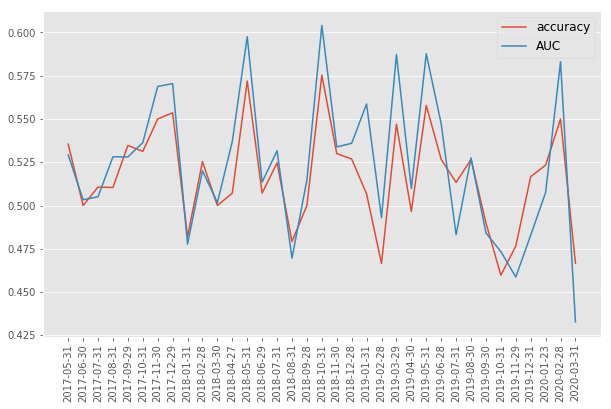

In [178]:
accu_1,auc_1,group_df1 = model_evaluation(knn,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_1,auc_1)

作图成功!


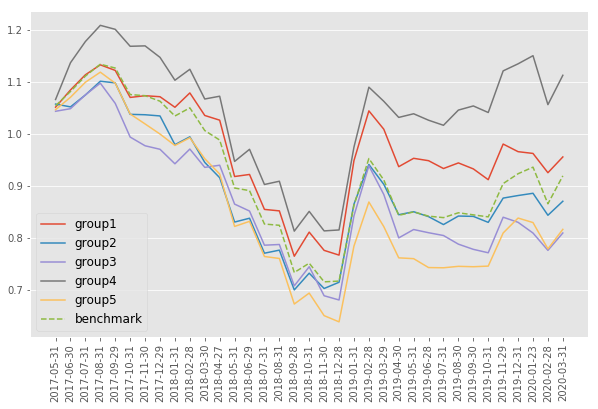

In [179]:
# 净值曲线
visualization(group_df1)

In [326]:
# 策略各项指标
eval1 = evaluation(group_df1)
eval1

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,-4.4%,-13.0%,-19.1%,11.3%,-18.3%,-8.1%
年化收益率,-1.53%,-4.66%,-7.01%,3.74%,-6.7%,-2.85%
最大回撤,32.47%,36.41%,37.96%,32.72%,42.89%,36.88%
夏普比率,-0.91,-1.54,-1.73,-0.04,-1.7,-1.18
年化超额收益率,1.32%,-2.08%,-4.14%,6.73%,-3.74%,0.0%
月最大超额收益,3.67%,2.75%,3.43%,4.54%,2.47%,0.0%
跑赢基准月份占比,51.43%,54.29%,42.86%,65.71%,40.0%,0.0%
正收益月份占比,40.0%,45.71%,37.14%,57.14%,40.0%,42.86%
信息比率,0.87,-1.32,-2.24,4.43,-3.44,NaN


## 5.2 逻辑回归

**样本内正确率和AUC**

In [181]:
from sklearn.linear_model import LogisticRegression

In [116]:
lg = LogisticRegression()
params = {'C':[0.001,0.01,0.1,1,10,100,1000]
            ,'max_iter':[100,200,300]
            ,'penalty' : ['l1','l2'] }
lg_GS = GridSearchCV(estimator=lg,param_grid=params,cv=5)
lg_GS.fit(X_wrapper,y)

# 输出最佳模型结果
print(lg_GS.best_score_) #0.547038188631109
# 输出最佳模型参数
print(lg_GS.best_params_) #{'C': 1000, 'max_iter': 300, 'penalty': 'l1'}

0.547038188631109
{'C': 1000, 'max_iter': 300, 'penalty': 'l1'}


In [182]:
lg = LogisticRegression(C=1000,max_iter=300,penalty='l1')

In [183]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(lg,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  #accuracy = 0.5458

auc_train = cross_val_score(lg,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))   #auc = 0.5637

样本内交叉验证 : 
	 accuracy = 0.5470
	 auc = 0.5648


In [184]:
lg.fit(X_wrapper,y)
with open('lg.pkl','wb') as pf:
    pickle.dump(lg,pf)

**样本外选股策略表现**

精确度均值: 0.5322344124635915
AUC均值: 0.5502456578207222


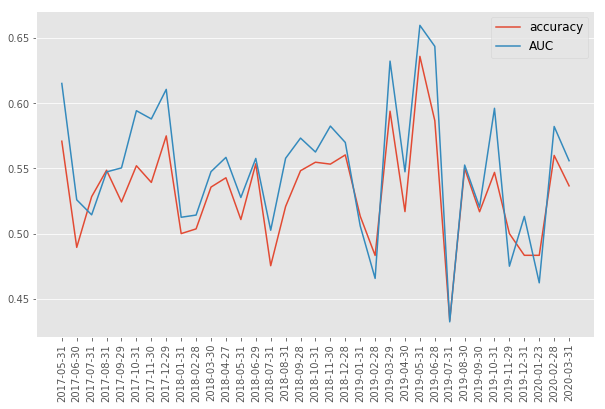

In [185]:
accu_2,auc_2,group_df2 = model_evaluation(lg,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_2,auc_2)

作图成功!


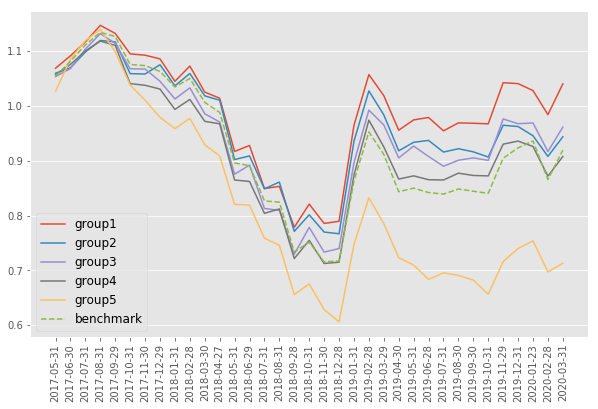

In [186]:
# 净值曲线
visualization(group_df2)

In [327]:
# 策略各项指标
eval2 = evaluation(group_df2)
eval2

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,4.0%,-5.6%,-3.9%,-9.2%,-28.7%,-8.1%
年化收益率,1.35%,-1.96%,-1.35%,-3.25%,-10.95%,-2.85%
最大回撤,32.1%,31.49%,35.54%,36.26%,46.79%,36.88%
夏普比率,-0.45,-1.03,-0.9,-1.2,-2.28,-1.18
年化超额收益率,4.21%,0.75%,1.52%,-0.36%,-8.05%,0.0%
月最大超额收益,3.25%,3.53%,4.27%,2.16%,3.14%,0.0%
跑赢基准月份占比,62.86%,54.29%,54.29%,51.43%,34.29%,0.0%
正收益月份占比,45.71%,45.71%,45.71%,42.86%,37.14%,42.86%
信息比率,3.15,0.63,1.09,-0.38,-4.51,NaN


## 5.3 决策树

**样本内正确率和AUC**

In [188]:
from sklearn.tree import DecisionTreeClassifier

In [147]:
tree = DecisionTreeClassifier()
params = {'criterion':['gini','entropy']
            ,'max_depth':[*range(3,8)]
            ,'min_samples_split' : [2,10,20,30,60] 
            ,'min_samples_leaf':[1,5,10,20,30]
         }
tree_GS = GridSearchCV(estimator=tree,param_grid=params,cv=5)
tree_GS.fit(X_wrapper,y)

# 输出最佳模型结果
print(tree_GS.best_score_) # 0.5413377979749661
# 输出最佳模型参数
print(tree_GS.best_params_) #{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 2}

0.5413377979749661
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 2}


In [189]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=30,min_samples_split=2)

In [190]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(tree,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train)) 
auc_train = cross_val_score(tree,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train)) 

样本内交叉验证 : 
	 accuracy = 0.5413
	 auc = 0.5535


In [191]:
tree.fit(X_wrapper,y)
with open('tree.pkl','wb') as pf:
    pickle.dump(tree,pf)

**样本外选股策略表现**

精确度均值: 0.527373215879334
AUC均值: 0.5320893246232962


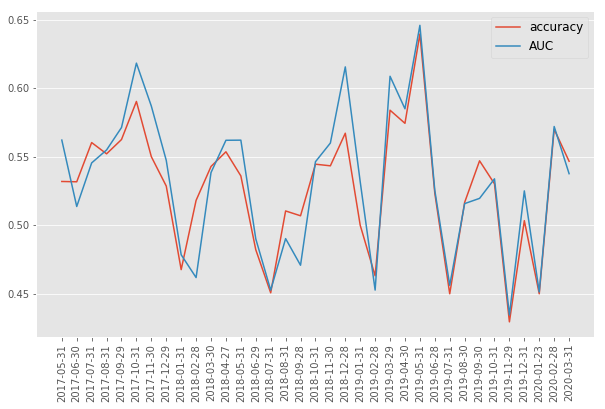

In [192]:
accu_3,auc_3,group_df3 = model_evaluation(tree,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_3,auc_3)

作图成功!


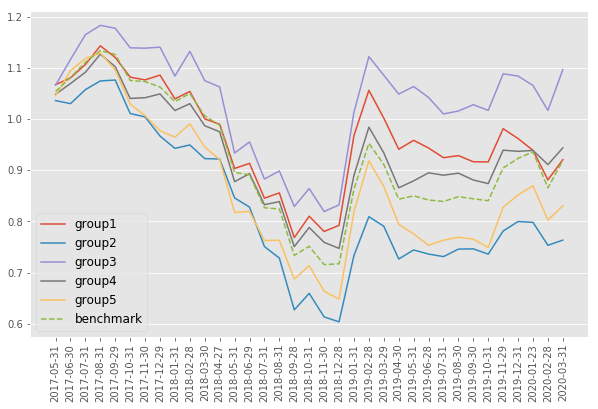

In [193]:
# 净值曲线
visualization(group_df3)

In [328]:
# 这里我之前用不作特征筛选的X,得到第三组的累计收益竟然为 246% 什么鬼???
eval3 = evaluation(group_df3)
eval3

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,-7.9%,-23.7%,9.7%,-5.6%,-16.9%,-8.1%
年化收益率,-2.78%,-8.86%,3.23%,-1.96%,-6.15%,-2.85%
最大回撤,32.79%,43.91%,30.76%,33.68%,42.59%,36.88%
夏普比率,-1.15,-2.12,-0.13,-1.07,-1.46,-1.18
年化超额收益率,-0.06%,-6.16%,6.18%,0.63%,-2.88%,0.0%
月最大超额收益,3.01%,2.72%,4.07%,4.57%,5.99%,0.0%
跑赢基准月份占比,48.57%,37.14%,62.86%,42.86%,42.86%,0.0%
正收益月份占比,45.71%,40.0%,48.57%,51.43%,45.71%,42.86%
信息比率,0.04,-3.47,3.31,0.6,-1.76,NaN


## 5.4 高斯朴素贝叶斯

**样本内正确率和AUC**

In [195]:
from sklearn.naive_bayes import GaussianNB

In [196]:
# 这个是最简单的模型了,没有什么调的参数
bys = GaussianNB()

In [197]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(bys,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))
auc_train = cross_val_score(bys,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))   

样本内交叉验证 : 
	 accuracy = 0.5478
	 auc = 0.5671


In [198]:
bys.fit(X_wrapper,y)
with open('bys.pkl','wb') as pf:
    pickle.dump(bys,pf)

**样本外选股策略表现**

精确度均值: 0.5315505984171724
AUC均值: 0.5435616382238325


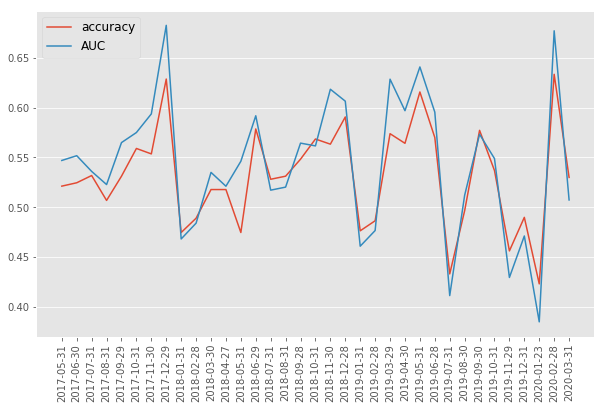

In [199]:
accu_4,auc_4,group_df4 = model_evaluation(bys,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_4,auc_4)

作图成功!


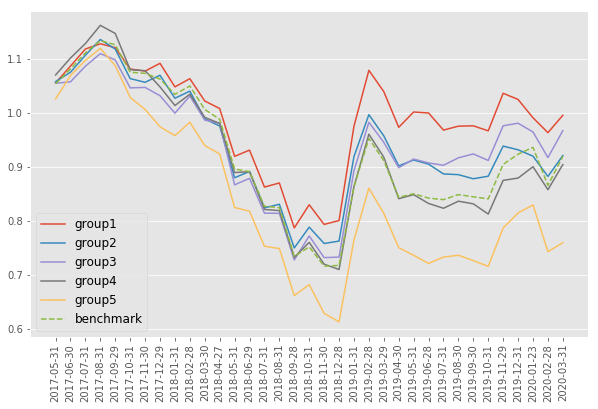

In [200]:
# 净值曲线
visualization(group_df4)

In [329]:
eval4 = evaluation(group_df4)
eval4

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,-0.5%,-7.9%,-3.3%,-9.6%,-24.1%,-8.1%
年化收益率,-0.17%,-2.78%,-1.14%,-3.4%,-9.02%,-2.85%
最大回撤,30.27%,34.03%,34.48%,38.96%,45.3%,36.88%
夏普比率,-0.73,-1.22,-0.86,-1.21,-1.89,-1.18
年化超额收益率,2.5%,-0.24%,1.73%,-0.44%,-5.82%,0.0%
月最大超额收益,4.73%,3.42%,3.68%,2.79%,4.48%,0.0%
跑赢基准月份占比,65.71%,51.43%,51.43%,54.29%,31.43%,0.0%
正收益月份占比,48.57%,45.71%,48.57%,42.86%,40.0%,42.86%
信息比率,1.52,0.04,1.23,-0.54,-3.4,NaN


## 5.5 随机森林

**样本内正确率和AUC**

In [202]:
from sklearn.ensemble import RandomForestClassifier

In [160]:
# 用时: 2h
rfc = RandomForestClassifier()
params = {'n_estimators':[50,100,200,300]
            ,'max_depth':[*range(3,6)]
            ,'min_samples_split' : [2,10,20,30] 
            ,'min_samples_leaf':[1,5,10,20]
         }
rfc_GS = GridSearchCV(estimator=rfc,param_grid=params,cv=5)
rfc_GS.fit(X_wrapper,y)

# 输出最佳模型结果
print(rfc_GS.best_score_)  # 0.5486327034999602
# 输出最佳模型参数
print(rfc_GS.best_params_) #{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 200}

0.5486327034999602
{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 200}


In [203]:
rfc = RandomForestClassifier(n_estimators=200
                            ,max_depth=5
                            ,min_samples_leaf=20
                            ,min_samples_split=20
                           )

In [204]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(rfc,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  #accuracy = 0.5474

auc_train = cross_val_score(rfc,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))  #auc = 0.5667

样本内交叉验证 : 
	 accuracy = 0.5474
	 auc = 0.5667


In [205]:
rfc.fit(X_wrapper,y)
with open('rfc.pkl','wb') as fp:
    pickle.dump(rfc,fp)

**样本外选股策略表现**

精确度均值: 0.5314499983204094
AUC均值: 0.5457900157168392


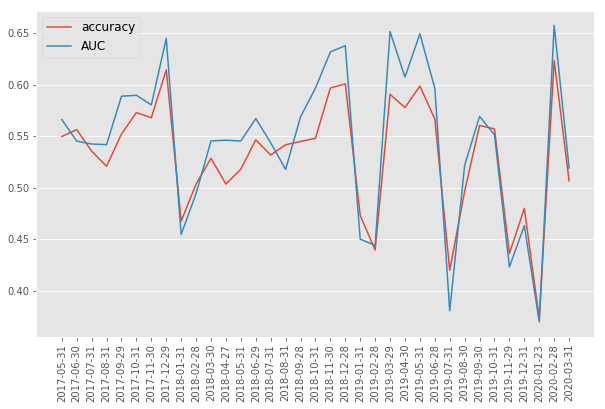

In [206]:
accu_5,auc_5,group_df5 = model_evaluation(rfc,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_5,auc_5)

作图成功!


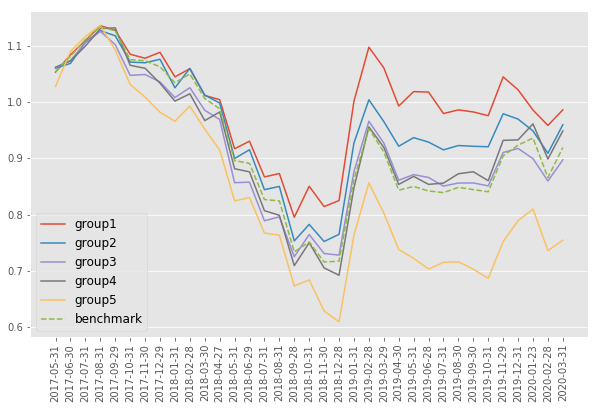

In [207]:
visualization(group_df5)

In [330]:
eval5 = evaluation(group_df5)
eval5

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,-1.4%,-4.0%,-10.3%,-5.1%,-24.6%,-8.1%
年化收益率,-0.48%,-1.39%,-3.66%,-1.78%,-9.23%,-2.85%
最大回撤,29.99%,33.25%,35.58%,38.85%,46.38%,36.88%
夏普比率,-0.79,-0.94,-1.33,-0.9,-1.9,-1.18
年化超额收益率,2.06%,1.27%,-0.97%,1.37%,-6.03%,0.0%
月最大超额收益,4.75%,3.34%,3.09%,3.4%,5.02%,0.0%
跑赢基准月份占比,57.14%,57.14%,51.43%,45.71%,31.43%,0.0%
正收益月份占比,45.71%,45.71%,48.57%,51.43%,42.86%,42.86%
信息比率,1.19,0.96,-0.64,0.78,-3.1,NaN


## 5.6 Adaboost

**样本内正确率和AUC**

In [209]:
from sklearn.ensemble import AdaBoostClassifier

In [210]:
adb = AdaBoostClassifier()
params = {
    'base_estimator':[DecisionTreeClassifier(max_depth=5)],
    'n_estimators' : [50,100,200,300],
    'learning_rate': [0.01,0.1,1,10,100]
}
adb_GS = GridSearchCV(estimator=adb,param_grid=params,cv=5)
adb_GS.fit(X_wrapper,y)
# 输出最佳模型结果
print(adb_GS.best_score_) 
# 输出最佳模型参数
print(adb_GS.best_params_)  #'learning_rate': 0.01, 'n_estimators': 200}

0.5460814797097983
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'learning_rate': 0.01, 'n_estimators': 200}


In [211]:
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)
                         ,learning_rate=0.01
                        , n_estimators=200)

In [213]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(adb,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  #accuracy = 0.5452

auc_train = cross_val_score(adb,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))  #auc = 0.5617

样本内交叉验证 : 
	 accuracy = 0.5452
	 auc = 0.5617


In [214]:
adb.fit(X_wrapper,y)
with open('adb.pkl','wb') as fp:
    pickle.dump(adb,fp)

**样本外选股策略表现**

精确度均值: 0.5299957605281223
AUC均值: 0.5387628101944242


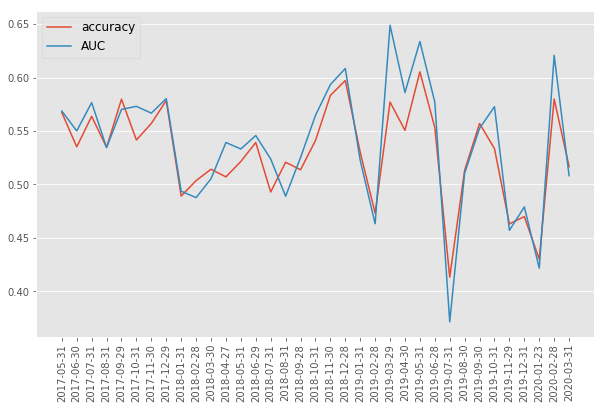

In [215]:
accu_6,auc_6,group_df6 = model_evaluation(adb,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_6,auc_6)

作图成功!


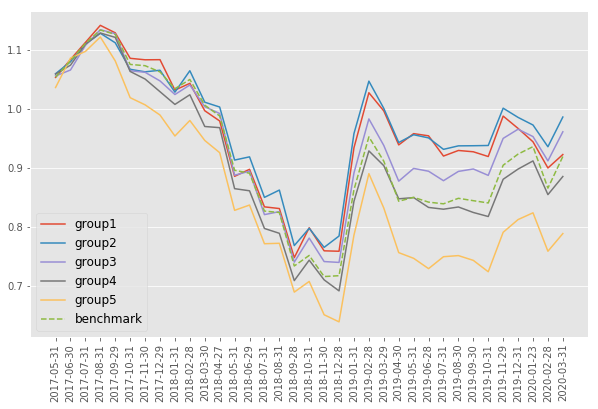

In [217]:
visualization(group_df6)

In [331]:
eval6 = evaluation(group_df6)
eval6

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,-7.7%,-1.4%,-3.9%,-11.5%,-21.1%,-8.1%
年化收益率,-2.71%,-0.48%,-1.35%,-4.1%,-7.8%,-2.85%
最大回撤,34.51%,32.19%,34.8%,38.75%,43.06%,36.88%
夏普比率,-1.12,-0.77,-0.92,-1.36,-1.77,-1.18
年化超额收益率,0.02%,2.29%,1.47%,-1.29%,-4.7%,0.0%
月最大超额收益,4.34%,3.73%,3.19%,2.45%,3.12%,0.0%
跑赢基准月份占比,45.71%,57.14%,54.29%,42.86%,40.0%,0.0%
正收益月份占比,40.0%,51.43%,45.71%,40.0%,45.71%,42.86%
信息比率,0.08,1.67,1.26,-1.11,-3,NaN


## 5.7 支持向量机

**样本内正确率和AUC**

In [219]:
from sklearn.svm import SVC

In [220]:
# 这里参考华泰研报的结果选择的参数, 感兴趣的朋友也可以自己网格搜索一下
svm = SVC(C=0.003,kernel='rbf',gamma=0.01)

In [221]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(svm,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  

auc_train = cross_val_score(svm,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5395
	 auc = 0.5639


In [222]:
svm.fit(X_wrapper,y)
with open('svm.pkl','wb') as fp:
    pickle.dump(svm,fp)

**样本外选股策略表现**

精确度均值: 0.5283741274061623
AUC均值: 0.5459457359714868


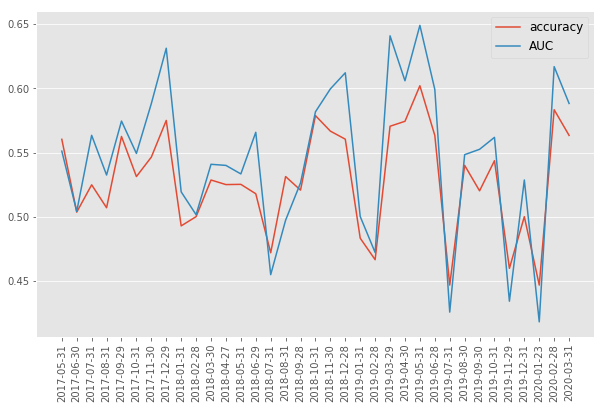

In [223]:
accu_7,auc_7,group_df7 = model_evaluation(svm,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_7,auc_7)

作图成功!


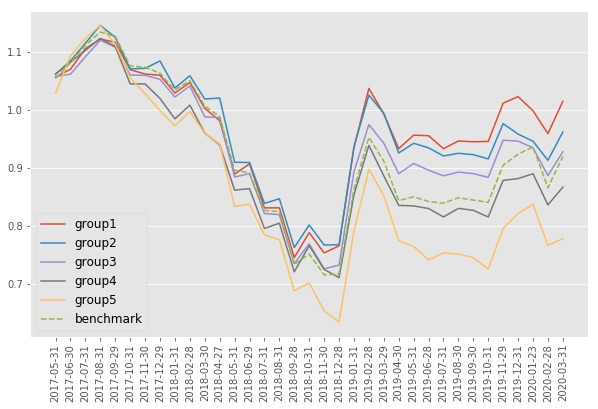

In [224]:
visualization(group_df7)

In [332]:
eval7 = evaluation(group_df7)
eval7

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,1.4%,-3.8%,-7.2%,-13.3%,-22.2%,-8.1%
年化收益率,0.48%,-1.32%,-2.53%,-4.78%,-8.25%,-2.85%
最大回撤,33.55%,33.42%,35.17%,36.7%,44.58%,36.88%
夏普比率,-0.59,-0.91,-1.12,-1.52,-1.79,-1.18
年化超额收益率,3.39%,1.45%,0.2%,-2.11%,-5.11%,0.0%
月最大超额收益,3.57%,4.04%,2.4%,3.78%,4.29%,0.0%
跑赢基准月份占比,62.86%,57.14%,54.29%,40.0%,37.14%,0.0%
正收益月份占比,48.57%,48.57%,40.0%,42.86%,40.0%,42.86%
信息比率,2.42,1.02,0.26,-1.56,-2.77,NaN


## 5.8 XGBoost

**样本内正确率和AUC**

In [227]:
from xgboost import XGBClassifier

In [233]:
xgb = XGBClassifier(n_estimators=200,max_depth=5)
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(xgb,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  

auc_train = cross_val_score(xgb,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5387
	 auc = 0.5539


In [236]:
xgb.fit(X_wrapper,y)
with open('xgb.pkl','wb') as fp:
    pickle.dump(xgb,fp)

**样本外选股策略表现**

精确度均值: 0.5248505777753909
AUC均值: 0.5330631277938327


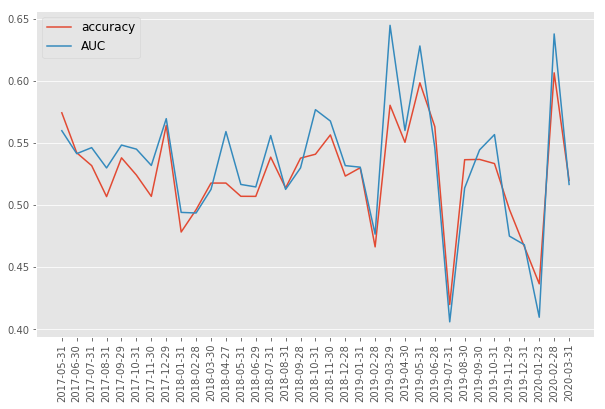

In [238]:
accu_8,auc_8,group_df8 = model_evaluation(xgb,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_8,auc_8)

作图成功!


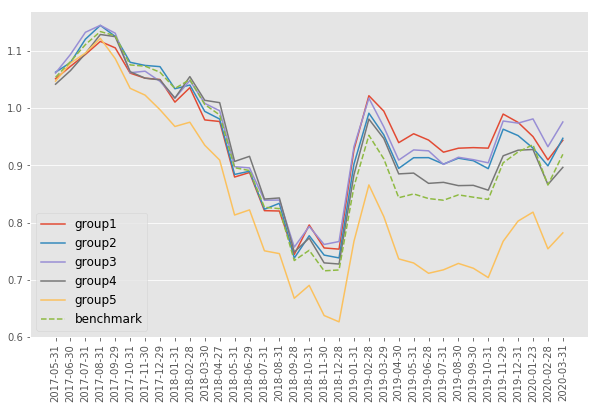

In [239]:
visualization(group_df8)

In [333]:
eval8 = evaluation(group_df8)
eval8

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,-5.6%,-5.3%,-2.4%,-10.4%,-21.8%,-8.1%
年化收益率,-1.96%,-1.85%,-0.83%,-3.7%,-8.09%,-2.85%
最大回撤,33.35%,35.53%,33.86%,35.54%,44.16%,36.88%
夏普比率,-1.01,-0.98,-0.83,-1.3,-1.84,-1.18
年化超额收益率,0.76%,0.99%,1.95%,-0.85%,-5.0%,0.0%
月最大超额收益,4.49%,4.18%,2.56%,2.17%,2.51%,0.0%
跑赢基准月份占比,45.71%,51.43%,62.86%,48.57%,37.14%,0.0%
正收益月份占比,40.0%,42.86%,45.71%,48.57%,42.86%,42.86%
信息比率,0.52,0.68,1.75,-0.81,-3.65,NaN


# 总结

In [241]:
models = ['KNN','Logistic','DecisionTree','Bayes','RF','AdaBoost','SVM','XGBoost']

## 各个模型样本外精确度和AUC
各个模型好像都差不多,其中逻辑回归表现最好

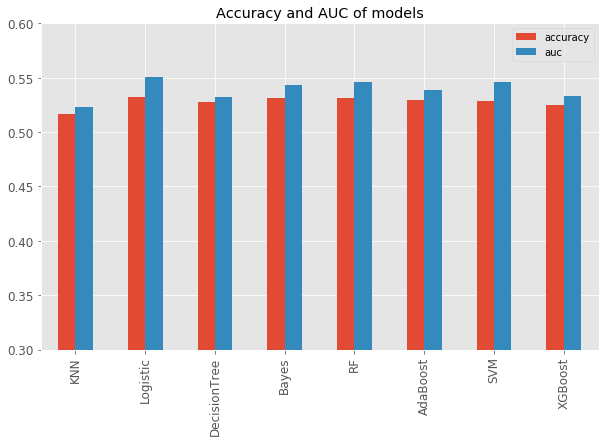

In [283]:
df = pd.DataFrame([[mean(accu_1),mean(accu_2),mean(accu_3),mean(accu_4),mean(accu_5),mean(accu_6),mean(accu_7),mean(accu_8)]
                      ,[mean(auc_1),mean(auc_2),mean(auc_3),mean(auc_4),mean(auc_5),mean(auc_6),mean(auc_7),mean(auc_8)]]
                 ,index=['accuracy','auc']).T
df.index = models

df.plot(kind='bar',figsize=(10,6),ylim=[0.3,0.6],title='Accuracy and AUC of models',fontsize=12)

plt.show()

## 各个模型组合1的净值曲线

In [294]:
group1_all = pd.DataFrame(index=group_df1.index,columns=models+['benchmark'])

In [295]:
for i,df in enumerate([group_df1,group_df2,group_df3,group_df4,group_df5,group_df6,group_df7,group_df8]):
    if i == 7:
        group1_all.iloc[:,i+1] = df['benchmark']
    group1_all.iloc[:,i] = df['group1']


可以看到 , 所有模型的组合1都跑赢了中证500 ,其中逻辑回归的表现最好

In [314]:
(group1_all+1).cumprod().iloc[-1,:].sort_values()

benchmark       0.919260
DecisionTree    0.920699
AdaBoost        0.922612
XGBoost         0.943805
KNN             0.955611
RF              0.986144
Bayes           0.995485
SVM             1.014489
Logistic        1.039984
Name: 2020-03-31, dtype: float64

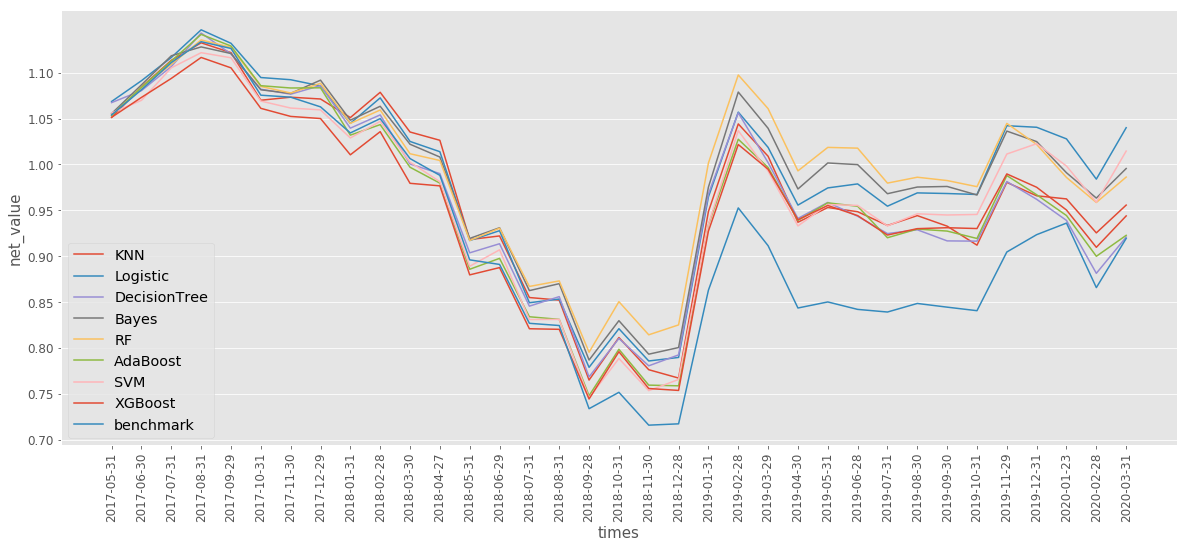

In [324]:
plt.figure(figsize=(20,8))
group1_all.index = [str(i) for i in group1_all.index]
plt.plot((group1_all+1).cumprod())
plt.xlabel('times',fontsize=15)
plt.ylabel('net_value',fontsize=15)
plt.xticks(rotation=90,fontsize=12)
plt.yticks([0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1],fontsize=12)
plt.legend(group1_all.columns,fontsize='x-large')
plt.grid(axis='x')
plt.show()

## 各个模型组合1的策略评价指标

In [337]:
eval_df = pd.DataFrame(index=eval1.index,columns=models)

In [338]:
for i,df in enumerate([eval1,eval2,eval3,eval4,eval5,eval6,eval7,eval8]):
    if i == 7:
        eval_df['benchmark'] = df['比较基准']
    eval_df.iloc[:,i] = df['第一组']

In [339]:
eval_df

,KNN,Logistic,DecisionTree,Bayes,RF,AdaBoost,SVM,XGBoost,benchmark
累计收益率,-4.4%,4.0%,-7.9%,-0.5%,-1.4%,-7.7%,1.4%,-5.6%,-8.1%
年化收益率,-1.53%,1.35%,-2.78%,-0.17%,-0.48%,-2.71%,0.48%,-1.96%,-2.85%
最大回撤,32.47%,32.1%,32.79%,30.27%,29.99%,34.51%,33.55%,33.35%,36.88%
夏普比率,-0.91,-0.45,-1.15,-0.73,-0.79,-1.12,-0.59,-1.01,-1.18
年化超额收益率,1.32%,4.21%,-0.06%,2.5%,2.06%,0.02%,3.39%,0.76%,0.0%
月最大超额收益,3.67%,3.25%,3.01%,4.73%,4.75%,4.34%,3.57%,4.49%,0.0%
跑赢基准月份占比,51.43%,62.86%,48.57%,65.71%,57.14%,45.71%,62.86%,45.71%,0.0%
正收益月份占比,40.0%,45.71%,45.71%,48.57%,45.71%,40.0%,48.57%,40.0%,42.86%
信息比率,0.87,3.15,0.04,1.52,1.19,0.08,2.42,0.52,NaN
